#Prevedere il numero di noleggi orario di biciclette

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Virginia Foschi     
Matricola: 0001030497

##Introduzione
Negli ultimi anni, l'uso delle biciclette come mezzo di trasporto ha registrato un aumento significativo, grazie alla sua sostenibilità ambientale, alla facilità d'uso e alla promozione di uno stile di vita attivo. In molti contesti urbani, i sistemi di bike-sharing hanno reso le biciclette facilmente accessibili agli utenti, consentendo loro di noleggiarle per brevi periodi di tempo.

A seguito di un'analisi dei dati raccolti da un sistema di bike-sharing londinese, l'obiettivo del progetto è quindi identificare il modello di regressione più accurato nel predire il numero di noleggi orario di biciclette sulla base delle condizioni meteorologiche.

###Caricamento Librerie
Per prima cosa carichiamo le librerie per effettuare operazioni sui dati

- _NumPy_ per creare e operare su array a N dimensioni
- _pandas_ per caricare e manipolare dati tabulari
- _matplotlib_ per creare grafici

Importiamo le librerie usando i loro alias convenzionali

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

##Caricamento dei dati
Carichiamo ora il dataset contenente le condizioni metereologiche e il numero di biciclette noleggiate in ciascuna ora ottenuto da [Kaggle](https://www.kaggle.com/datasets)
.

Il dataset contiene dati relativi a due anni di noleggi di biciclette a Londra, dal 01/04/2015 al 01/04/2017, con misurazioni orarie del numero di noleggi effettuati e delle condizioni meteorologiche del momento.

###Significato delle colonne

Le feature presenti nel Dataset sono:
- timestamp: raccoglie informazioni sulla data e l'ora di ogni osservazione.
- cnt: è il numero di noleggi effettuati. Corrisponde alla variabile da prevedere.
- t1 e t2: sono rispettivamente la temperatura media e la temperatura percepita media per ogni ora.
- hum e wind_speed: raccolgono informazioni sull'umidità media e sulla velocità media del vento per ogni ora.
- weather_code: indica la situazione meteorologica in forma codificata:
  - 1 = Sereno/parzialmente sereno
  - 2 = Nuvole sparse/poche nuvole
  - 3 = Nuvole irregolari/parzialmente nuvoloso
  - 4 = Nuvoloso/nebbia
  - 7 = Pioggia/pioggia leggera/rovescio leggero
  - 10 = Pioggia con temporale
  - 26 = Nevicata
  - 94 = Nebbia ghiacciata
- is_holiday e is_weekend: assumono il valore "1" se il giorno dell'osservazione è un giorno festivo o un giorno del weekend.
- season: è un valore compreso tra 0 e 3 (inclusi) che identifica la stagione:
  - 0 = spring
  - 1 = summer
  - 2 = fall
  - 3 = winter

In [3]:
import os.path
file = "./london_merged.csv";
if not os.path.exists(file):
    print("Missing dataset, retrieve it from Kaggle at this link https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset");
else:
  bike = pd.read_csv(file, index_col=False, encoding='latin1');

In [4]:
bike.info(memory_usage="deep");

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.5 MB


In [5]:
bike.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [6]:
bike.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


La tabella ottenuta mostra alcune statistiche sui valori di ciascuna colonna, utili ad analizzarne la distribuzione come:
- `count` = valori non mancanti, ovvero diversi da NA
  - in questo caso non ci sono valori mancanti, quindi tutti i count sono pari al numero di righe (17414)
- `mean` = media
  - ad esempio la media dei noleggi per ora è di circa 1143 biciclette
- `25%`/`50%`/`75%` = percentili
  - ad es. nel 75% delle ore è stata rilevata un temperatura media **inferiore a** 16°C

###Preprocessing dei dati

Rinomino alcune colonne per migliorarne la comprensione:

In [7]:
bike = bike.rename(columns={'cnt':'num_bikes','hum':'humidity'})

####Aggiunta variabili
I dati di timestamp non sono molto utili per noi nel formato attuale. Per incorporarli nel nostro modello di regressione lineare, dovremo estrarre l'ora, il giorno e il mese dal timestamp

In [8]:
bike["timestamp"] = pd.to_datetime(bike["timestamp"])

bike["month"] = bike.timestamp.dt.month
bike["hour"] = bike.timestamp.dt.hour
bike["weekday"] = bike.timestamp.dt.weekday

bike = bike.drop("timestamp", axis=1)

Per migliorare l'interpretabilità dei risultati successivi, sostituiamo inoltre i numeri nella colonna `season`,  `weather_code`, `weekday` e `month` con nomi abbreviati significativi. Una volta definito un dizionario che mappa ciascuno dei valori distinti attualmente nella colonna al valore con cui si vuole sostituire...

In [9]:
index_to_season = {
    0: 'spring',
    1: 'summer',
    2: 'autumn',
    3: 'winter'
}

index_to_weather_code = {
      1: "clear",
      2: "few_clouds",
      3: "clouds",
      4: "cloudy",
      7: "rain",
      10: "storm",
      26: "snow",
      94: "fog"
}

index_to_dayOfWeek = {
    0:'Mon',
    1:'Tue',
    2:'Wed',
    3:'Thu',
    4:'Fri',
    5:'Sat',
    6:'Sun'
}

index_to_month = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'May',
    6:'June',
    7:'July',
    8:'Aug',
    9:'Sept',
    10:'Oct',
    11:'Nov',
    12:'Dic'
}

...possiamo usare il metodo `map` per ottenere una colonna con i valori sostituiti, che convertiamo poi a categorica.

In [10]:
bike['season'] = bike.season.map(index_to_season).astype("category")

bike['weather_code'] = bike.weather_code.map(index_to_weather_code).astype("category")

bike["weekday"] = bike.weekday.map(index_to_dayOfWeek).astype("category")

bike["month"] = bike.month.map(index_to_month).astype("category")

In [11]:
bike.head()

,num_bikes,t1,t2,humidity,wind_speed,weather_code,is_holiday,is_weekend,season,month,hour,weekday
0,182,3.0,2.0,93.0,6.0,clouds,0.0,1.0,winter,Jan,0,Sun
1,138,3.0,2.5,93.0,5.0,clear,0.0,1.0,winter,Jan,1,Sun
2,134,2.5,2.5,96.5,0.0,clear,0.0,1.0,winter,Jan,2,Sun
3,72,2.0,2.0,100.0,0.0,clear,0.0,1.0,winter,Jan,3,Sun
4,47,2.0,0.0,93.0,6.5,clear,0.0,1.0,winter,Jan,4,Sun


#### Dati mancanti
Si rilevano, se presenti, valori nulli nel dataset.  
Possiamo applicare `isna` ad un frame e usare a cascata un metodo di aggregazione per verificare la presenza di valori mancanti nelle singole colonne.

In [12]:
bike.isna().any()

num_bikes       False
t1              False
t2              False
humidity        False
wind_speed      False
weather_code    False
is_holiday      False
is_weekend      False
season          False
month           False
hour            False
weekday         False
dtype: bool

Come già visto anche con il metodo `info`, in questo dataset non sono presenti valori nulli e quindi non risulta necessario trattare questi ultimi.

####Tipi di dato
Usiamo il metodo `info` per ottenere informazioni sui tipi di colonne e sul peso in memoria del frame caricato.

In [13]:
bike.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   num_bikes     17414 non-null  int64   
 1   t1            17414 non-null  float64 
 2   t2            17414 non-null  float64 
 3   humidity      17414 non-null  float64 
 4   wind_speed    17414 non-null  float64 
 5   weather_code  17414 non-null  category
 6   is_holiday    17414 non-null  float64 
 7   is_weekend    17414 non-null  float64 
 8   season        17414 non-null  category
 9   month         17414 non-null  category
 10  hour          17414 non-null  int32   
 11  weekday       17414 non-null  category
dtypes: category(4), float64(6), int32(1), int64(1)
memory usage: 1.1 MB


pandas ha usato tipi numerici (`int32`,`int64`,`float64`) dove ha trovato dati numerici. Sappiamo però che le colonne `is_holiday` e `is_weekend` sono binarie, ovvero hanno solo valori 0 e 1. Possiamo quindi sostituire queste colonne con le loro conversioni in serie booleane usando il metodo `astype`

In [15]:
bike["is_holiday"] = bike["is_holiday"].astype(bool)
bike["is_weekend"] = bike["is_weekend"].astype(bool)

Sappiamo inoltre che le colonne `month` e `hour` sono di tipo categorico: per queste è possibile usare il tipo di dato `category` che memorizza in modo efficiente colonne di questo tipo e fornisce operazioni specifiche.

In [16]:
bike["month"] = bike["month"].astype("category")
bike["hour"] = bike["hour"].astype("category")

Queste conversioni aiutano a ridurre il peso in memoria del dataset.

In [17]:
bike.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   num_bikes     17414 non-null  int64   
 1   t1            17414 non-null  float64 
 2   t2            17414 non-null  float64 
 3   humidity      17414 non-null  float64 
 4   wind_speed    17414 non-null  float64 
 5   weather_code  17414 non-null  category
 6   is_holiday    17414 non-null  bool    
 7   is_weekend    17414 non-null  bool    
 8   season        17414 non-null  category
 9   month         17414 non-null  category
 10  hour          17414 non-null  category
 11  weekday       17414 non-null  category
dtypes: bool(2), category(5), float64(4), int64(1)
memory usage: 802.8 KB


##Analisi esplorativa
Visualizziamo alcune statistiche per prendere coscienza dei dati che dovremo analizzare e delle caratteristiche del dominio applicativo.

In [18]:
import seaborn as sns

def var_correlation(dataset):

    # Select only numeric columns from the dataset
    numeric_cols = dataset.select_dtypes(include=np.number)

    # Compute the correlation matrix
    corr_matrix = numeric_cols.corr()

    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

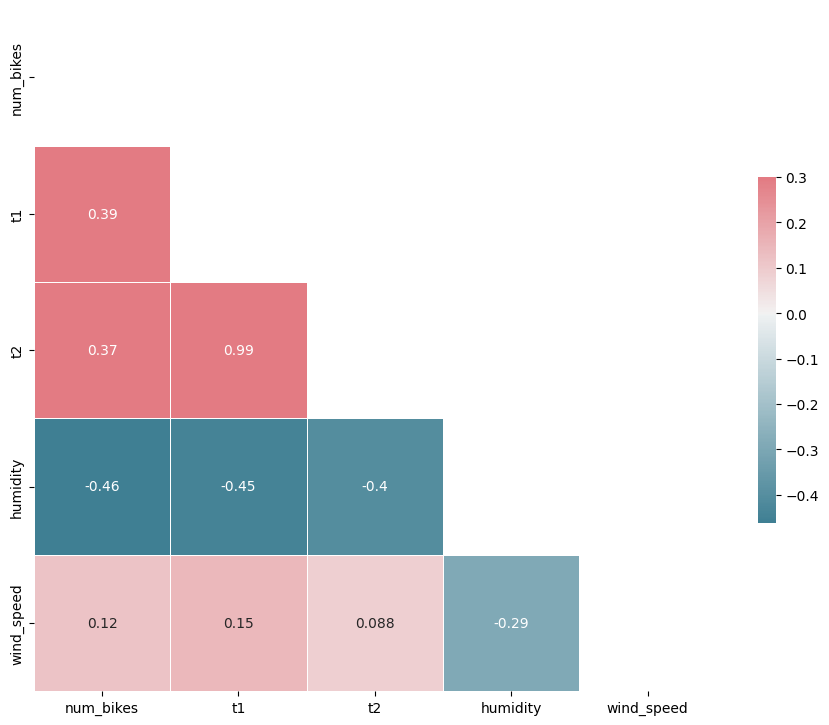

In [19]:
var_correlation(bike)

Il dataset non mostra nessun parametro con una correlazione forte (> 75%) con la variabile dipendente `num_bikes`: la temperatura reale e percepita sembrano leggermente correlate positivamente con il numero di biciclette noleggiate, così come la variabile `wind_speed`. Al contrario, l'umidità mostra una correlazione negativa.

I grafici a dispersione, ottenuti attraverso la libreria matplotlib, confermano visivamente le leggere correlazioni osservate per gli attributi presenti nel dataframe.

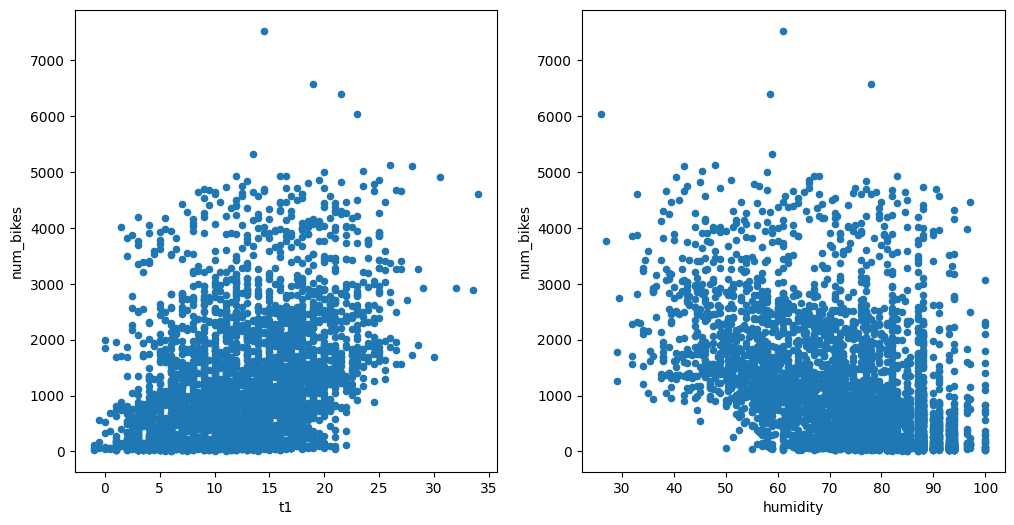

In [20]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
bike.sample(4000, random_state=42).plot.scatter("t1", "num_bikes", ax=ax1)

ax2 = fig.add_subplot(122)
bike.sample(4000, random_state=42).plot.scatter("humidity", "num_bikes", ax=ax2)

plt.show()

Esaminiamo anche i dati relativi all'ora, al mese e al giorno della settimana per identificare se ci sono periodi in cui il noleggio di biciclette è più elevato.

<Axes: xlabel='weekday', ylabel='num_bikes'>

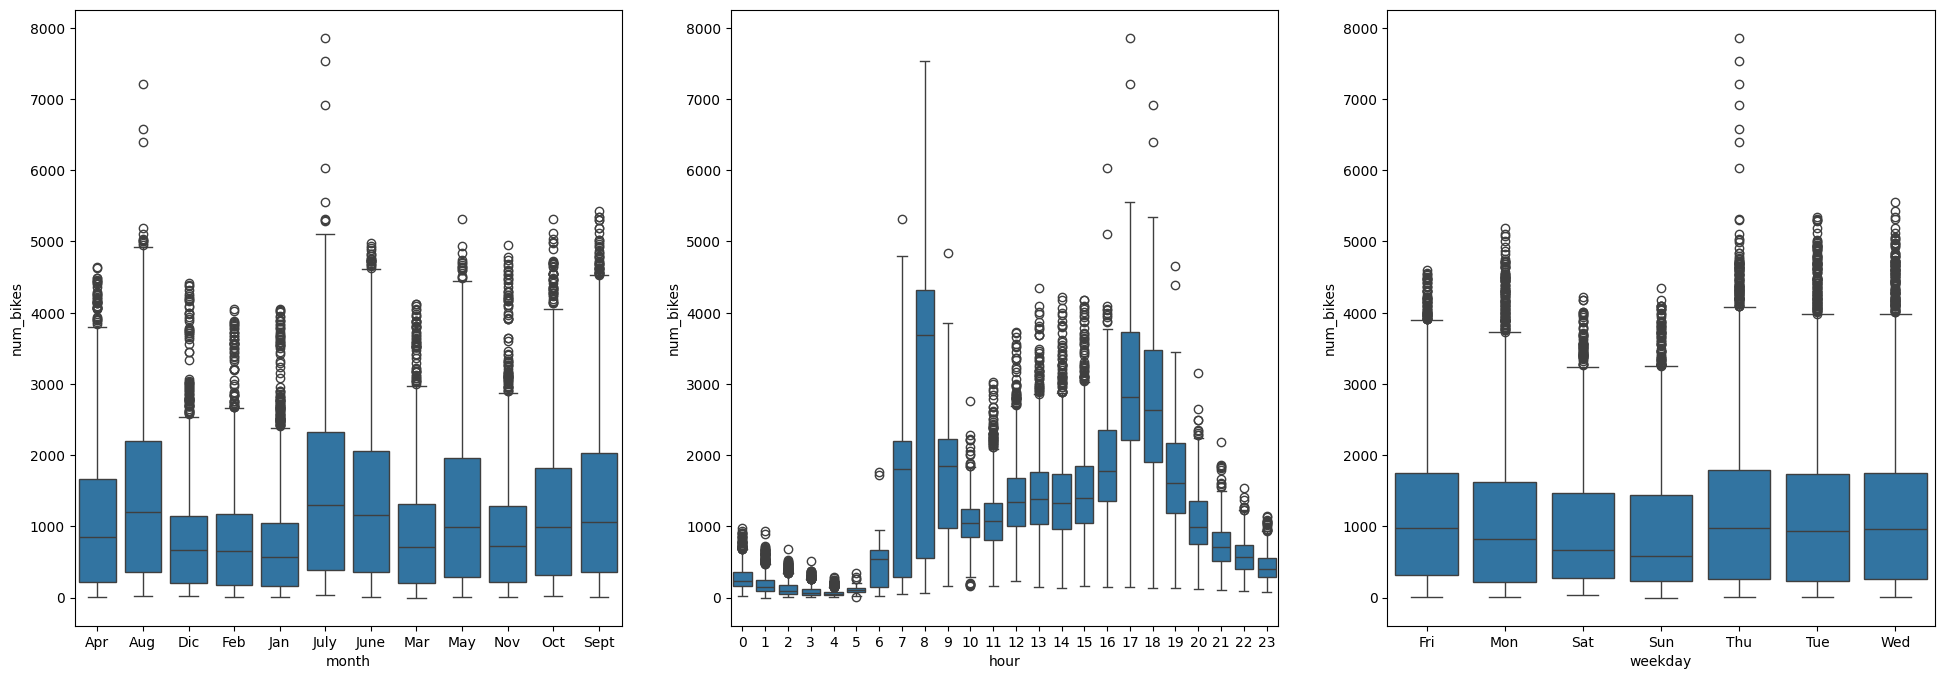

In [21]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(24, 8)

sns.boxplot(data=bike, x='month', y='num_bikes', ax=ax1)
sns.boxplot(data=bike, x='hour', y='num_bikes', ax=ax2)
sns.boxplot(data=bike, x='weekday', y='num_bikes', ax=ax3)

Analizzando il box plot del mese, si osserva un picco durante l'estate, in particolare a luglio, con i mesi da aprile a ottobre che registrano conteggi più alti rispetto al resto dell'anno. Il box plot dell'ora mostra il traffico più intenso durante le ore di punta per pendolari al mattino (7-9) e nel pomeriggio (16-19), con un forte calo durante la notte quando è buio. Il box plot del giorno della settimana mostra una modesta diminuzione il sabato e la domenica a causa del weekend

<BarContainer object of 3 artists>

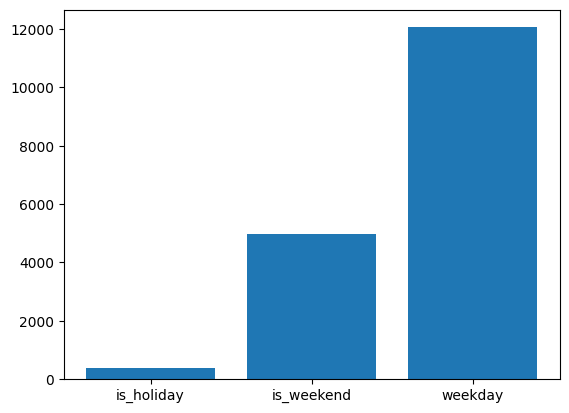

In [22]:
data = {'is_holiday':len(bike[bike['is_holiday'] == 1]), 'is_weekend':len(bike[bike['is_weekend'] == 1]),
        'weekday':len(bike[(bike['is_holiday'] != 1) & (bike['is_weekend'] != 1)]) }

plt.bar(list(data.keys()), list(data.values()))

Visualizzando infatti il numero di bicilette noleggiate nei giorni feriali, festivi e durante le vacanze, si può notare che il numero di noleggi durante le vacanze è quasi trascurabile e che la maggior parte delle biciclette vengono noleggiate durante la settimana

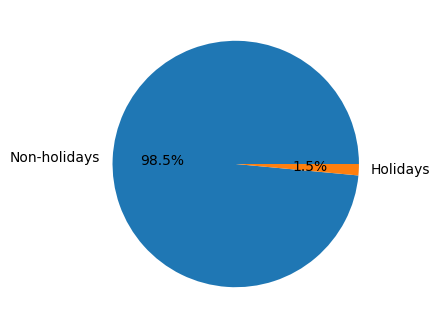

In [23]:
data=bike.groupby('is_holiday')['num_bikes'].sum()
plt.figure(figsize=(4,4))
plt.pie(data.values, labels=["Non-holidays", "Holidays"], autopct='%1.1f%%')
plt.show()

Possiamo notare infatti che solo l'1,5% di biciclette sono noleggiate durante le vacanze.

Guardiamo ora come il clima e le diverse stagioni influiscono sul noleggio delle biciclette.

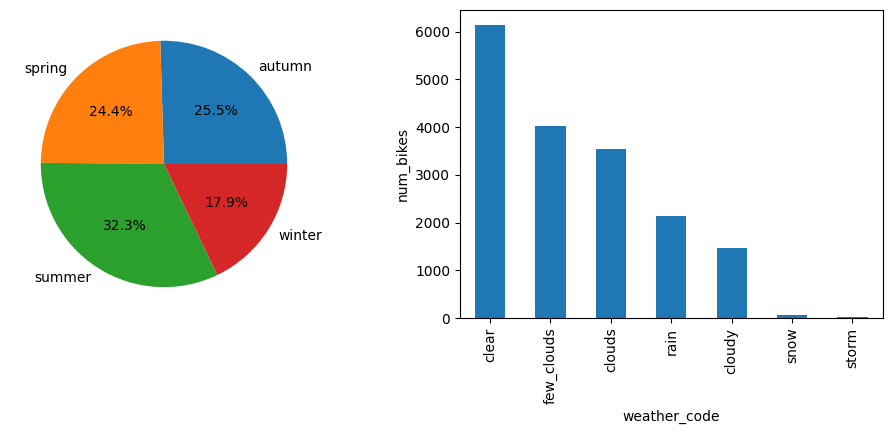

In [24]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
data=bike.groupby('season')['num_bikes'].sum()
data.plot.pie(labels=data.index.tolist() , autopct='%1.1f%%', ax=ax1, ylabel='')

ax2 = fig.add_subplot(122)
bike["weather_code"].value_counts().plot.bar(ax=ax2, ylabel="num_bikes")
plt.show()

Confrontando il noleggio di biciclette nelle diverse stagioni, osserviamo che l'estate ha il numero più alto di noleggi, seguita dall'autunno e dalla primavera. Il grafico a barre infatti dimostra che le persone preferiscono climi caldi o piacevoli rispetto a climi più freddi.

##Preparazione dei dati

Abbiamo visto che `t2` ha una correlazione del 99% con `t1` che corrisponde alla temperatura reale media. Siccome dipendenze tra le variabili in input rendono la regressione instabile, cioè piccole variazioni nei dati generano modelli molto diversi e inaffidabili, eliminiamo la corrispondente colonna dal dataframe.

In [25]:
bike = bike.drop(columns=["t2"])

Abbiamo visto inoltre che l'uso della bicicletta è significativamente più elevato nelle prime ora del mattino e nel tardo pomeriggio. Aggiungo quindi una nuova colonna `is_rush_hour` al dataframe che,  siccome contiene informazioni utili per spiegare la variazione della variabile dipendente, potrebbe aiutare il modello a fare previsioni più accurate.

In [26]:
def is_rush_hour(hour):
    if (7 <= hour <= 9) or (16 <= hour <= 19):
        return 1
    else:
        return 0

bike['is_rush_hour'] = bike['hour'].apply(is_rush_hour).astype(bool)

Per la predizione utilizzeremo quasi tutte le colonne.

Molte variabili hanno valori numerici, ma di diversa natura:

  1. alcune variabili (es. `wind_speed`) esprimono effettivamente una quantità o una grandezza
  2. altre variabili (es. `is_weekend`) sono binarie, valgono 1 dove la condizione è verificata e 0 dove non si verifica
  3. altre variabili (es. `season`) sono di tipo "nominale"

Creiamo tre liste con i nomi delle variabili che vogliamo usare per la predizione, suddivise nei rispettivi gruppi.

In [27]:
numeric_vars = ["t1", "humidity", "wind_speed"]
binary_vars = ["is_holiday", "is_weekend", "rush_hour"]
categorical_vars = ['weather_code', 'season', 'month', 'hour', 'weekday']

Per prima cosa dobbiamo convertire le features categoriche in valori numerici mediante binarizzazione in modo da poterle utilizzare nella regressione. Ad esempio, la variabile categorica `season` prevede 4 classi. Mediante questo metodo vengono create 4 colonne, `season_spring`, `season_summer`, `season_autumn` e `season_winter`, in cui sarà presente un 1 in corrispondenza della classe di appartenenza e 0 negli altri casi.

In [28]:
bike = pd.get_dummies(bike, columns=categorical_vars, prefix=categorical_vars)
bike.head(1)

,num_bikes,t1,humidity,wind_speed,is_holiday,is_weekend,is_rush_hour,weather_code_clear,weather_code_clouds,weather_code_cloudy,...,hour_21,hour_22,hour_23,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
0,182,3.0,93.0,6.0,False,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False


Analizzando la distribuzione della variabile target, possiamo notare che è fortemente asimmetrica in quanto la maggior parte dei valori sono concentrati sul lato sinistro della media. Siccome i dati distorti posso influire sulle prestazioni di molti algoritmi trasformo la variabile traget applicandone la radice quadrata.

In [29]:
before = bike["num_bikes"]
bike["num_bikes"] = np.sqrt(bike["num_bikes"])

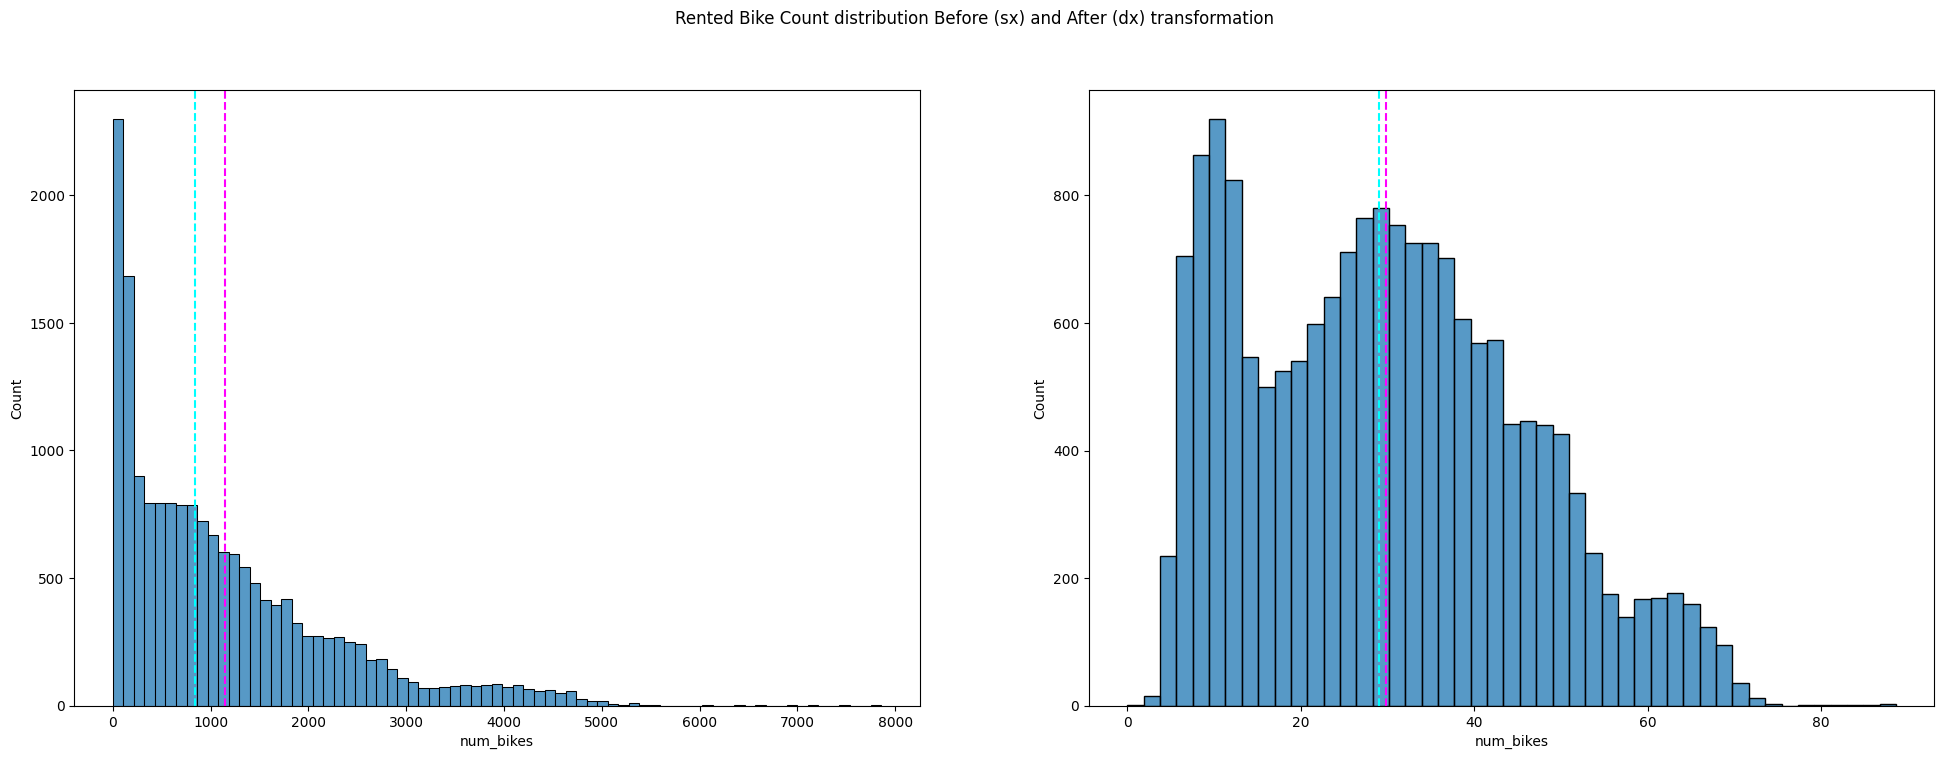

In [33]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(24, 8)
figure.suptitle("Rented Bike Count distribution Before (sx) and After (dx) transformation")

sns.histplot(before, ax=ax1)
ax1.axvline(before.mean(), color='magenta', linestyle='dashed')
ax1.axvline(before.median(), color='cyan', linestyle='dashed')
sns.histplot(bike["num_bikes"], ax=ax2)
ax2.axvline(bike["num_bikes"].mean(), color='magenta', linestyle='dashed')
ax2.axvline(bike["num_bikes"].median(), color='cyan', linestyle='dashed')

plt.show()

Estraiamo dal frame

- la serie `y` con i valori della variabile `num_bikes` da prevedere
- il frame `X` con i valori di tutte le altre variabili, utilizzabili per la predizione

In [34]:
from scipy import stats
X = bike.drop('num_bikes', axis=1)
y = bike['num_bikes']

Dividiamo i dati caricati casualmente in training e validation set con la funzione `train_test_split`

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
print(f'Training Set: {X_train.shape[0]} rows\nTest Set: {X_val.shape[0]} rows')

Training Set: 11609 rows
Test Set: 5805 rows


##Addestramento

Ora creiamo i modelli con l'ausilio delle Pipeline di sklearn.

Proviamo diversi modelli di regressione utilizzando la grid search per individuare un set di iperparametri che massimizzi l'accuratezza.

Importiamo per prima cosa le librerie necessarie:

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
#sopprimiamo i warning della GridSearch
import warnings
warnings.filterwarnings("ignore")

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    n = X.shape[0]
    p = X.shape[1]
    r2_agg = 1- (1-r2)*((n-1)/(n-p))
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")
    print(f"R-squared-agg coefficient: {r2_agg:.5}")

In [38]:
def evaluate_model(X, y, model):
    print_eval(X, y, model)

    y_pred=model.predict(X)
    plt.title("Actual v/s Predicted bike count")
    ax1 = sns.distplot(y,hist=False,color="green",label="Actual")
    sns.distplot(y_pred,hist=False,color='red',label="Predicted",ax = ax1)
    plt.legend(title='legend', loc='upper right', labels=['Actual Value', 'Predicted Value'])
    plt.show()

###Regressione Lasso
Testiamo se, con la regressione Lasso, possiamo eliminare alcune feature perché poco rilevanti.

Creiamo una pipeline e facciamo partire la grid search che testa il modello in 5-cross fold validation secondo il set di iperparametri che gli chiediamo di valutare.

In [39]:
model = Pipeline([
    ("preprc", StandardScaler()),
    ("linreg", Lasso())
])
grid = {
    "linreg__alpha": [0.1, 1, 3, 5]
}
gs = GridSearchCV(model, param_grid=grid, cv=5, return_train_score=True, error_score='raise')
gs.fit(X_train, y_train)
sel = ["mean_test_score", "mean_train_score", "params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

,mean_test_score,mean_train_score,params
0,0.782570,0.784786,{'linreg__alpha': 0.1}
1,0.697737,0.699175,{'linreg__alpha': 1}
2,0.485134,0.485873,{'linreg__alpha': 3}
3,0.345026,0.345715,{'linreg__alpha': 5}


Scelgo il parametro più piccolo in quanto è possibile notare che l'accuratezza peggiora con una regolarizzazione più forte e addestro un modello con lo scopo di individuare le feature più rilevanti.

In [40]:
model = Pipeline([
    ("preproc", StandardScaler()),
    ("regr", Lasso(alpha=0.1))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preproc', StandardScaler()), ('regr', Lasso(alpha=0.1))])

In [42]:
lasso = pd.Series(model.named_steps["regr"].coef_, X_train.columns).sort_values(ascending=False)
c = len(lasso[lasso!=0])
print("Features totali: "+ str(len(X_train.columns)))
print("Features estratte: "+ str(c))
lasso[lasso!=0]

Features totali: 60
Features estratte: 41


is_rush_hour               5.737213
t1                         2.873786
hour_17                    1.930965
hour_8                     1.852385
hour_15                    1.742783
hour_18                    1.661258
hour_13                    1.624038
hour_12                    1.559932
hour_14                    1.461061
hour_11                    0.853722
hour_10                    0.840339
hour_20                    0.740899
month_Oct                  0.323494
weather_code_few_clouds    0.273999
month_June                 0.081402
month_May                  0.051337
hour_16                    0.028904
weekday_Thu                0.027237
month_Apr                 -0.042837
weather_code_cloudy       -0.093854
month_Mar                 -0.133783
hour_19                   -0.148584
weekday_Sun               -0.197783
weather_code_storm        -0.213883
weekday_Mon               -0.233883
hour_7                    -0.273498
season_winter             -0.348534
hour_22                   -0

Vediamo che sono state selezionate un sottoinsieme delle caratteristiche del modello ovvero le caratteristiche che la regolarizzazione Lasso ha individuato come più importanti e informative per predire la variabile dipendente. Come già notato durante l'analisi esplorativa, temperatura e orario di punta rappresentano le feature che contribuiscono maggiormente nella previsione del modello.

Selezioniamo solo le feature che non sono state annullate dalla Lasso poichè considerate irrilevanti.

In [43]:
keep = lasso[lasso!=0].index.tolist()
bike_lasso = bike[keep+["num_bikes"]]
bike_lasso.head(1)

,is_rush_hour,t1,hour_17,hour_8,hour_15,hour_18,hour_13,hour_12,hour_14,hour_11,...,is_weekend,weather_code_rain,hour_0,hour_1,humidity,hour_5,hour_2,hour_4,hour_3,num_bikes
0,False,3.0,False,False,False,False,False,False,False,False,...,True,False,True,False,93.0,False,False,False,False,13.490738


In [44]:
X = bike_lasso.drop(columns="num_bikes")
y = bike_lasso["num_bikes"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

###Regressione Ridge
Testiamo ora il modello di regressione Ridge per valutare le performance di un modello di regressione lineare applicando però una regolarizzazione per evitare che i coefficienti crescano troppo. Applico inoltre la standardizzazione delle feature che permette, in presenza di variabile con scale diverse, di uniformarne i valori e migliorare l'accuratezza del modello.

In [45]:
from sklearn.linear_model import Ridge
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
grid = {
    "linreg__alpha": [0.1, 1, 5, 10]
    }
gs = GridSearchCV(model, param_grid=grid, return_train_score=True, cv=5)
gs.fit(X_train, y_train)
sel = ["mean_test_score", "mean_train_score", "params"]
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

,mean_test_score,mean_train_score,params
3,0.784238,0.786382,{'linreg__alpha': 10}
2,0.784238,0.786383,{'linreg__alpha': 5}
1,0.784237,0.786383,{'linreg__alpha': 1}
0,0.784236,0.786383,{'linreg__alpha': 0.1}


Possiamo vedere che il valore di alpha, che rappresenta il peso della regolarizzazione, non modifica particolarmente i risultati ottenuti. Siccome la regolarizzazione non sembra influire in modo significativo sul risultato, proviamo ad addestrare un semplice modello di regressione lineare per confrontarne l'accuratezza.

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = Pipeline([
    ("scale",  StandardScaler(with_mean=False)),
    ("linreg", LinearRegression())
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.7981842939693614

Possiamo notare infatti che l'accuratezza è praticamente uguale a quella della regressione Ridge.

###Regressione con funzioni Kernel
Testiamo ora il modello di regressione con funzione kernel polinomiale.La regressione con funzione kernel polinomiale permette di ottenere modelli non lineari mappando i dati originali in un nuovo spazio ad elevata dimensionalità senza dover creare le relative nuove variabili.

In [47]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(kernel="poly"))
])
grid = {
    "regr__degree": range(2,3),
    "regr__alpha": [0.01, 0.1, 1, 10],
}
gs = GridSearchCV(model, grid, cv=5, return_train_score=True)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)[sel]

,mean_test_score,mean_train_score,params
1,0.958272,0.963551,"{'regr__alpha': 0.1, 'regr__degree': 2}"
0,0.958198,0.963610,"{'regr__alpha': 0.01, 'regr__degree': 2}"
2,0.957013,0.961668,"{'regr__alpha': 1, 'regr__degree': 2}"
3,0.933227,0.937107,"{'regr__alpha': 10, 'regr__degree': 2}"


Possiamo vedere che l'accuratezza migliora rispetto ai modelli lineari.

###Random Forest
Vediamo ora per confronto cosa accade con un modello di regressione random forest testando diversi valori per gli iperparametri che regolano la complessità del modello.

In [48]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
grid = {
    "max_samples": [0.2,0.3],
    "n_estimators": [10,20,100],
    "max_features": ["sqrt"]
}

gs = GridSearchCV(model, param_grid=grid, cv=5, return_train_score=True, n_jobs=-1)

gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False).iloc[:3][sel]

,mean_test_score,mean_train_score,params
5,0.924458,0.957954,"{'max_features': 'sqrt', 'max_samples': 0.3, '..."
4,0.916773,0.952098,"{'max_features': 'sqrt', 'max_samples': 0.3, '..."
2,0.914761,0.942329,"{'max_features': 'sqrt', 'max_samples': 0.2, '..."


In [49]:
print("R-Squared::{}".format(gs.best_score_))
print("Best Hyperparameters::\n{}".format(gs.best_params_))

R-Squared::0.9244584649303219
Best Hyperparameters::
{'max_features': 'sqrt', 'max_samples': 0.3, 'n_estimators': 100}


###XGBoost
Testiamo infine XGBoost, un modello basato su gradient boosting, in cui gli alberi decisionali vengono creati in sequenza dagli errori residui del precedente.

In [51]:
from xgboost import XGBRegressor

xgbm = XGBRegressor(objective='reg:squarederror', reg_alpha=0.0, reg_lambda=1.0, n_estimators=100)
xgbm.fit(X_train, y_train)
xgbm.score(X_val, y_val)

0.9580826198259499

In [52]:
pd.Series(xgbm.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]

is_rush_hour    0.344969
hour_3          0.069295
hour_5          0.064211
hour_4          0.062648
hour_2          0.062200
hour_8          0.043365
hour_1          0.038603
hour_12         0.030529
is_weekend      0.028502
hour_0          0.027675
dtype: float32

Possiamo notare che tranne per `is_rush_hour`, XGBoost assegna un'importanza alle feature diversa rispetto alla Lasso

##Valutazione dei modelli migliori
Il modello di regressione con funzione kernel polinomiale e XGBoost ci hanno dato i risultati migliori. Andiamo a valutare questi modelli in modo più approfondito usando diverse metriche di valutazione.

In [53]:
from sklearn.metrics import mean_squared_error, r2_score

def rmspe(y_real, y_pred):
    return np.sqrt(np.mean((y_pred /y_real - 1) ** 2))

def print_eval_for_tree(X, y, model):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    n = X.shape[0]
    p = X.shape[1]
    r2_agg = 1- (1-r2)*((n-1)/(n-p))
    print(f"      MSE: {mean_squared_error(y, y_pred):12.4f}")
    print(f"R-squared: {r2:12.4f}")
    print(f"R-squared-agg coefficient: {r2_agg:.5}")
    print(f"    RMSPE: {rmspe(y, y_pred):12.4f}")

def evaluate_model_for_tree(X, y, model):
    print_eval_for_tree(X, y, model)

    y_pred=model.predict(X)
    plt.title("Actual v/s Predicted bike count")
    ax1 = sns.distplot(y,hist=False,color="green",label="Actual")
    sns.distplot(y_pred,hist=False,color='red',label="Predicted",ax = ax1)
    plt.legend(title='legend', loc='upper right', labels=['Actual Value', 'Predicted Value'])
    plt.show()

Addestriamo il modello di regressione con funzione kernel con i parametri migliori individuati con la grid search:

In [54]:
kernel_model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(degree=2, alpha=0.1, kernel="poly"))
])

kernel_model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('regr', KernelRidge(alpha=0.1, degree=2, kernel='poly'))])

Confrontiamo ora come questi modelli si comportano su dati mai visti

Modello di regressione con kernel polinomiale:
   Mean squared error: 9.4516
       Relative error: 9.21764%
R-squared coefficient: 0.9634
R-squared-agg coefficient: 0.96314


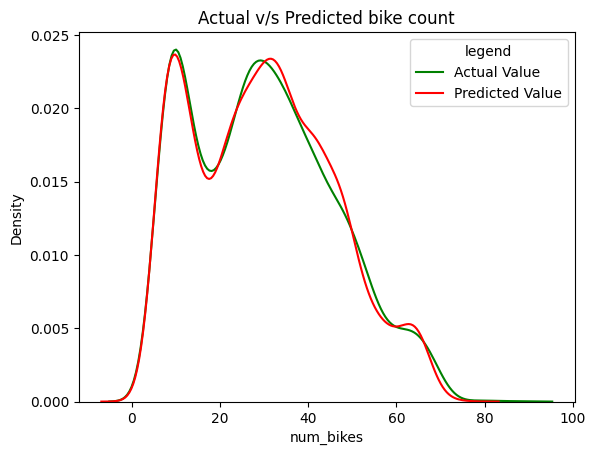

In [55]:
print("Modello di regressione con kernel polinomiale:")
evaluate_model(X_val, y_val, kernel_model)

XGBoost:
      MSE:      10.8236
R-squared:       0.9581
R-squared-agg coefficient: 0.95779
    RMSPE:       0.1567


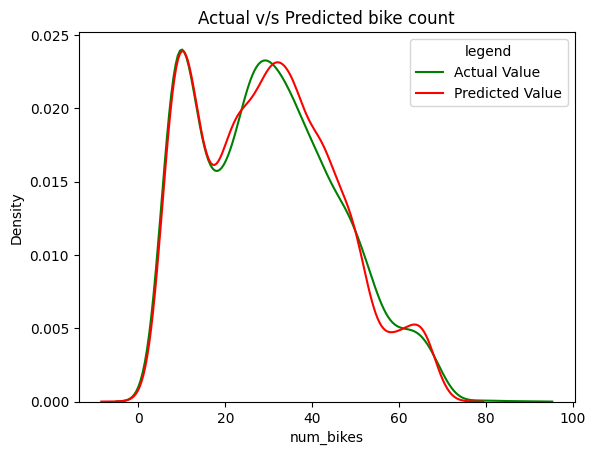

In [56]:
print("XGBoost:")
evaluate_model_for_tree(X_val, y_val, xgbm)

##Conclusioni
Osservando i valori delle varie metriche e i grafici, possiamo concludere che il modello che meglio approssima i dati è il modello di regressione con kernel polinomiale. Analizzando i valori delle metriche si percepisce che il modello ha una buona capacità predittiva e che le previsioni generalmente hanno un errore abbastanza contenuto. Il _coefficiente di determinazione_ $R^2$ con un valore prossimo a 1 infatti indica che il modello si adatta bene ai dati osservati mentre i valori di _MSE_ e _errore relativo_ indicano che gli errori di previsione sono moderati e ben gestiti rispetto alla variabilità dei dati reali.